# Ranked retrieval

Good for majority of users who wish to see results sorted by *relevance*.

## Approach 1: Jaccard coefficient
`Jaccard(A,B) = |A and B|/|A or B|`

### Pros
1. A and B dont have to be the same size
2. Always assigns a number b/w 0 and 1.

### Cons
1. Does not consider term frequency (we want to distinguish which term has high frequency vs low frequency) - the more frequent the term, the higher the relevance *should be*.

## Approach 2: Using term frequency and inverted document frequency

`tf = frequency of term d appearing in document d`  
Note: a document with 10x more freuency of this term does not mean that its 10x more relevant. (not proportional)

### Log frequency weighting

```
If (tf > 0)
    w = 1+log(tf)
else
    w = 0
```

Total score for a document-query pair:

`score = sum(1+log(tf))` from all terms in query AND document

### Document frequency

Rationale: Rare terms are more informative than frequent terms. eg. stop words concept  
`idf = log(N/df)`
- df = document frequency of term t, number of documents that contain the term t
- N is the total number of documents

Rarest/ low frequency words will have a larger `idf` value.

### Tf-idf weighting

`W = (1+log(tf))*log(N/df)`

#### Properties:
1. Increases with number of occurences within a document
2. Increases with rarity of the term in collection

#### Total score

`Score (q,d) = sum (tf-idf)` from all terms in query AND document

#### Issues:
1. We have a |V| dimensional space vector -> very large
2. Very sparse vectors, most are zero
3. No positional indexing and does not consider the ordering of words
4. If we feed a query with wrong word, we will get nothing

In [1]:
import nltk
import math


docs = {1:"who is aaryam, aaryam is a genius.", 
        2: "wilson is a hypocrite", 
        3: "tze guang is a guy who needs to chill is fab",
        4: "TTGHCS will become a reality, all hail Tze Guang",
        5: "Hit or miss, #road to 100 million for Pewds"
       }

query = input("input you query: ")
scores = {}
doc_freq = {}
doc_ranking = []

# Find document frequency of each term
for key in docs:
    text = docs[key]
    
    for term in list(set(nltk.word_tokenize(text))):
        if (term in doc_freq):
            doc_freq[term] += 1
        else:
            doc_freq[term] = 1
            

for key in docs:
    text = docs[key]
    term_freq = {}
    for term in nltk.word_tokenize(text):
        if (term not in term_freq):
            term_freq[term] = 1
        else:
            term_freq[term] += 1

    intersect = list(set(nltk.word_tokenize(text)) & set(nltk.word_tokenize(query)))
    
    # tf
    score_tf = sum(1 + math.log(term_freq[term]) for term in intersect)
    
    # idf
    score_idf = sum(math.log(len(docs)/float(doc_freq[term])) for term in intersect)
        
    print ("score for tf:", score_tf)
    print ("score for idf:", score_idf)
    print ("combined score:", score_tf*score_idf)
    doc_ranking.append((score_tf*score_idf, key))
    print ("=======================================================================")

print ("\nFinal result:")
doc_ranking.sort(reverse=True)
print (doc_ranking)


input you query: aaryam genius
score for tf: 2.6931471805599454
score for idf: 3.2188758248682006
combined score: 8.668906352316363
score for tf: 0
score for idf: 0
combined score: 0
score for tf: 0
score for idf: 0
combined score: 0
score for tf: 0
score for idf: 0
combined score: 0
score for tf: 0
score for idf: 0
combined score: 0

Final result:
[(8.668906352316363, 1), (0, 5), (0, 4), (0, 3), (0, 2)]


## Approach 3: text2vec cosine similarity model


Convert both query and document words into vectors. Perform tf.idf cosine similarity on them.

### Why euclidean distance is a bad idea

Distances in euclidean space are too large.  
Eg. a text with similar words similar distribution but one has much more word count. Their distances is very far apart even though they are similar in relevance

### Cosine similarity
Rank documents based on the angle distance to query.

#### Pros

1. Vectors are length normalised - making them comparable across different vectors despite their original lengths


In [2]:
import re, math
from collections import Counter
import nltk

def get_cosine(vec1, vec2):
    intersection = set(vec1.keys()) & set(vec2.keys())
    numerator = sum([vec1[x] * vec2[x] for x in intersection]) 
    # Tip: Perform these operations as matrix operations using numpy

    sum1 = sum([vec1[x]**2 for x in vec1.keys()])
    sum2 = sum([vec2[x]**2 for x in vec2.keys()])
    denominator = math.sqrt(sum1) * math.sqrt(sum2) # This makes it length normalised

    if not denominator:
        return 0.0
    else:
        return float(numerator) / denominator

def text_to_vector_ltc(text):
    words = nltk.word_tokenize(text)
    term_freq = Counter(words)
    term_score = {}

    # tf
    for term in list(set(words)):
        term_score[term] = 1 + math.log(term_freq[term])
    
    # idf
    for term in list(set(words)):
        term_score[term] *= math.log(len(words)/float(term_freq[term])) 
        # use len(words) as N to simulate each word as its own document
    return term_score


def text_to_vector_lnc(text):
    words = nltk.word_tokenize(text)
    term_freq = Counter(words)
    term_score = {}

    # tf
    for term in list(set(words)):
        term_score[term] = 1 + math.log(term_freq[term])
    
    # No idf
    return term_score



query = input("enter your query: ")
text2 = 'this sentence is similar to a foo bar sentence .'

vector1 = text_to_vector_ltc(query)
vector2 = text_to_vector_lnc(text2)

cosine = get_cosine(vector1, vector2)

print ('Cosine score:', cosine) # the larger the number, the more relevant


enter your query: hello world
Cosine score: 0.0


In [3]:
# Cosine score calculation with numpy
import numpy as np
from numpy import linalg as LA
import nltk
from collections import Counter
import math

query = "singapore"
doc_1 = "national national national university university university singapore singapore singapore of of of"
df = {"national": 500, "university": 700, "of": 750000, "singapore": 100}
total_docs = 1000000


tf_q = Counter(nltk.word_tokenize(query))
length_doc1 = len(nltk.word_tokenize(doc_1))
tf_doc1 = Counter(nltk.word_tokenize(doc_1))
print ("tf_q:", tf_q)
print ("tf_doc1:", tf_doc1)


# Create numpy array for query vector
# Find the universe between the 2 first

universe = set().union(tf_q, tf_doc1)
print("universe:", universe)

# Now that we have the union of the 2, let's create our numpy array
# We will take the ordering of terms with respect to universe now
print("")

# Calculate ltc of query
tf_idn_q = []
for x in universe:
    if (x not in tf_q):
        tf_idn_q.append(0)
    else:
        tf_idn_q.append((1+math.log10(tf_q[x]))*(math.log10(total_docs/float(df[x]))))
    
tf_idn_q = np.array(tf_idn_q)

# Calculate lnc of doc1
tf_idn_doc1 = []
for x in universe:
    if (x not in tf_doc1):
        tf_idn_doc1.append(0)
    else:
        tf_idn_doc1.append(1+math.log10(tf_doc1[x]))

tf_idn_doc1 = np.array(tf_idn_doc1)
tf_idn_doc1 = tf_idn_doc1.reshape(len(tf_idn_doc1), 1)
print("")

score = np.dot(tf_idn_q, tf_idn_doc1)

score /= length_doc1 # Very important step for normalising, divide by document length

print ("Cosine score:", score)

tf_q: Counter({'singapore': 1})
tf_doc1: Counter({'national': 3, 'university': 3, 'singapore': 3, 'of': 3})
universe: {'of', 'university', 'national', 'singapore'}


Cosine score: [0.49237375]


## Additional stuff

Weighting can differ in queries vs document. One very popular weighting scheme is the `lnc.ltc` scheme.

### Document side (lnc):
- l: logarithmic tf
- n: no idf
- c: cosine normalisation

### Query side (ltc):
- l: logarithmic tf
- t: logarithmic idf
- c: cosine normalisation

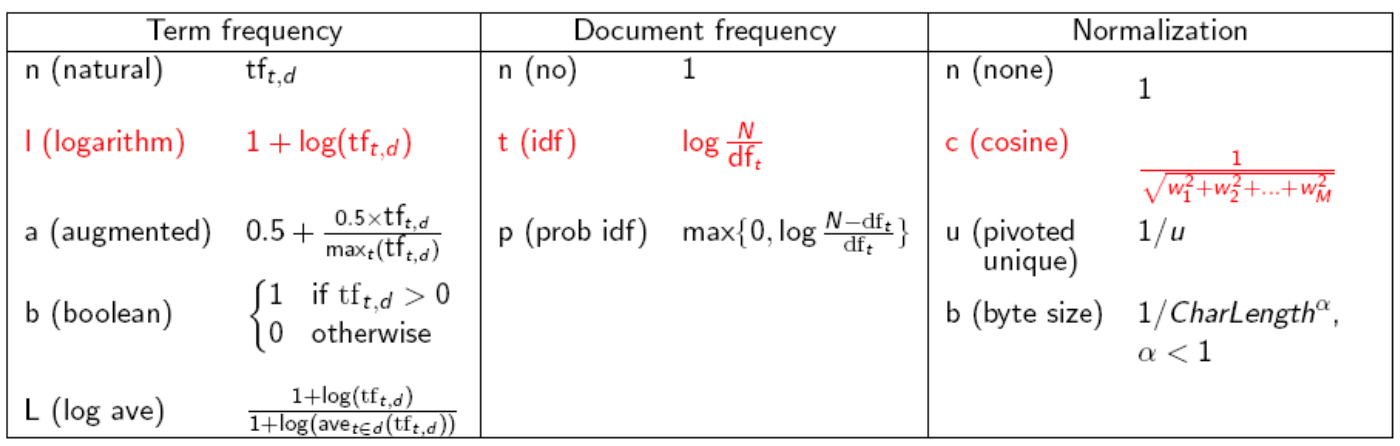